In [69]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from PIL import Image

# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [71]:
file_path = "train.csv" # load train.csv from kaggle api

# Load the latest version
train = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "alessandrasala79/ai-vs-human-generated-dataset",
  file_path,
)

# example of csv
print("First 5 records:", train.head())

C:\Users\ryanc\AppData\Local\Temp\ipykernel_27924\2128438290.py:4: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  train = kagglehub.load_dataset(


First 5 records:    Unnamed: 0                                        file_name  label
0           0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1           1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2           2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3           3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4           4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1


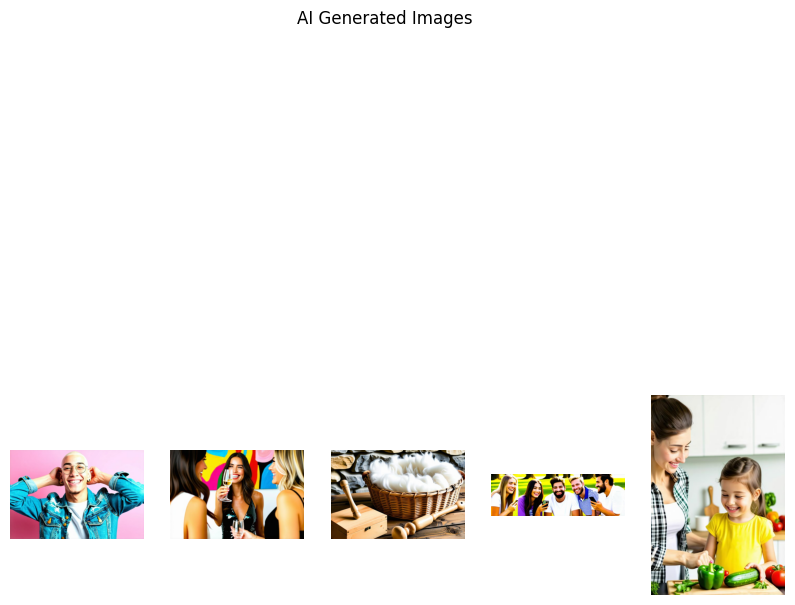

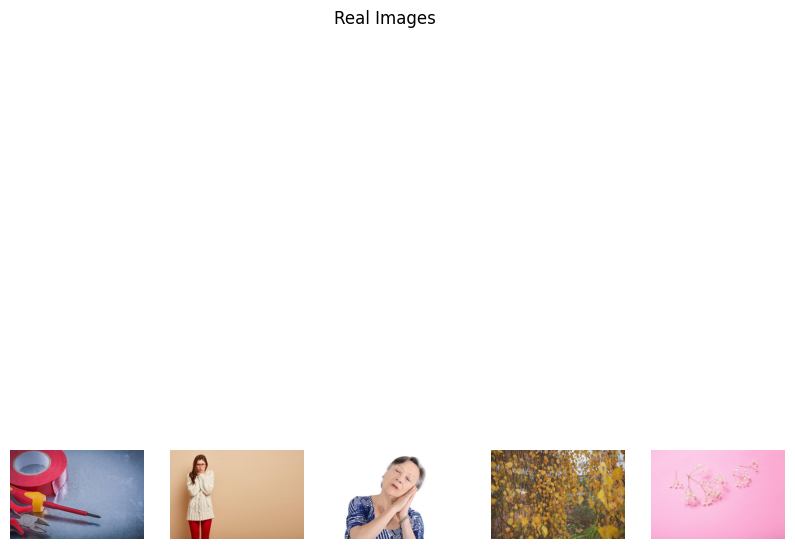

In [72]:
ai_generated_images = train[train["label"]==1]["file_name"].tolist() # separates all AI images in a list from train data
real_images = train[train["label"]==0]["file_name"].tolist() # separates all real images in a list from train data

# outputs 5 random images from the inputted image folder as example
def show_image(image_folder, title, num_images=5):
    plt.figure(figsize=(10, 10))
    # loop through random sample image folder
    for i, image in enumerate(random.sample(image_folder,num_images)):
        img = Image.open(image) # open image file
        plt.subplot(1, num_images, i + 1) # add image to subplot
        plt.imshow(img) # display image
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


show_image(ai_generated_images, title="AI Generated Images") # shows 5 random ai generated images
show_image(real_images, title="Real Images") # shows 5 random real images

In [73]:
# loads single image files with given label (0 or 1)
def load_image(file_name, label):
    img = Image.open(file_name).convert('RGB').resize((128,128)) # opens image, converts to rgb, and resizes to (128,128)
    img_array = np.array(img) / 255.0 # convert image to numpy array and normalize pixels
    return img_array.astype(np.float32), label

In [5]:
# returns image and label as compatible with tensorflow
def tensor_wrapper(file_name, label):
    img, label = tf.numpy_function(load_image, [file_name, label], [tf.float32, tf.int64])
    img.set_shape([128,128,3])
    label.set_shape([])
    return img, label

In [74]:
# extracts file_name and label values from the data
file_names = train["file_name"].values
labels = train["label"].values

dataset = tf.data.Dataset.from_tensor_slices((file_names, labels)) # creates a tensorflow dataset
dataset = dataset.map(tensor_wrapper) # applies the wrapper to load and process the data
dataset = dataset.batch(32).shuffle(1000).prefetch(tf.data.AUTOTUNE) # dataset batches in 32, shuffles data each epoch, and prefetch improves performance

In [75]:
def discriminator_model():
    """
    Returns a discriminator model using Convolutional Neural Network (CNN) architecture.

    Input:
    This function does not take any input.

    Returns:
    model : A tf.keras.Sequential model representing the discriminator
    """

    model = tf.keras.Sequential([
        # first convolutional layer, 64 filters, (5x5) kernel, (2x2) stride
        # input shape must be (128,128,3)
        tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(128,128,3)),
        tf.keras.layers.LeakyReLU(), # activation function
        tf.keras.layers.Dropout(0.3), # regularization to prevent overfitting
        # second convolutional layer, 128 filters
        tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        tf.keras.layers.LeakyReLU(), # activation function
        tf.keras.layers.Dropout(0.3), # regularization to prevent overfitting
        tf.keras.layers.Flatten(), # flatten to 1D vector
        tf.keras.layers.Dense(1, activation='sigmoid') # output layer, sigmoid activation (binary classification)
    ])

    return model

In [8]:
model = discriminator_model() # instantiate model

# adam optimizer and binary crossentropy loss compiled
# metric to be evaluated on is accuracy
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.fit(dataset, epochs=10) # model trained on the train data set for 10 epochs
model.save("discriminator_model.h5") # model training saved to a file

Epoch 1/10


C:\Users\ryanc\Desktop\cs549 project\.venv1\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2499/2499 ━━━━━━━━━━━━━━━━━━━━ 858s 249ms/step - accuracy: 0.8047 - loss: 0.4293
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 866s 248ms/step - accuracy: 0.8869 - loss: 0.2939
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 872s 247ms/step - accuracy: 0.8919 - loss: 0.3114
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 878s 252ms/step - accuracy: 0.9041 - loss: 0.2866
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 872s 249ms/step - accuracy: 0.9071 - loss: 0.3101
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 875s 250ms/step - accuracy: 0.9146 - loss: 0.3002
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 865s 248ms/step - accuracy: 0.9085 - loss: 0.3643
Epoch 8/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 869s 251ms/step - accuracy: 0.9159 - loss: 0.3551
Epoch 9/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 863s 245ms/step - accuracy: 0.9203 - loss: 0.3542
Epoch 10/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 785s 214ms/step - accuracy: 0.9235 - loss: 0.3580


In [125]:
def get_prediction(prediction):
    num = prediction.numpy()[0][0] # converts tensor to numpy

    # predicted probability greater than 0.5 is AI, else real image
    if num > 0.5:
        return 1 # label for AI
    else:
        return 0 # label for real


In [126]:
# First test
# AI images and real images are appended into a list in alternating order
# beginning with AI images. Since we know the expected prediction, the test should be easily validated
test_list = []
for i in range(10):
    test_list.append(ai_generated_images[i]) # add ai images
    test_list.append(real_images[i]) # add real images
for i in range(20):
    img = Image.open(test_list[i]).convert('RGB') # opens image and converts to rgb
    img = img.resize((128, 128)) # resize to (128, 128)
    array = np.array(img) / 255.0 # convert to array and normalize pixels
    array = np.expand_dims(array, axis=0)  # shape should be (128, 128, 3)
    prediction = model(array)  # Pass the image to the model
    pred_label = get_prediction(prediction) # outputs predictions
    if pred_label == 1:
        print("AI Generated Image")
    else:
        print("Real Image")


    # The output should display AI Generated Image and Real Image
    # in the order that it was appended

AI Generated Image
Real Image
AI Generated Image
Real Image
AI Generated Image
Real Image
AI Generated Image
Real Image
AI Generated Image
Real Image
AI Generated Image
Real Image
AI Generated Image
Real Image
AI Generated Image
Real Image
AI Generated Image
Real Image
AI Generated Image
Real Image


In [127]:
def test_model(model, dataset, expected_label):
    correct = 0 # correct predictions
    total = len(dataset) # total predictions

    for i, images in enumerate(dataset):
        expected = expected_label[i] # expected prediction label (0 or 1)
        img = Image.open(images).convert('RGB') # opens image and converts rgb
        img = img.resize((128,128)) # resize to (128,128)
        img_array = np.array(img) / 255.0 # converts to array and normalizes pixels
        img_array = np.expand_dims(img_array, axis=0) # shape should be (128, 128, 3)
        prediction = model(img_array) # pass image to model
        pred_label = get_prediction(prediction) # output prediction and save

        # determines results and displays test results
        result = "✅" if pred_label == expected else "❌"
        pred_label_str = "AI Generated Image" if pred_label == 1 else "Real Image"
        expected_label_str = "AI Generated Image" if expected == 1 else "Real Image"

        print(f"{result} Prediction: {pred_label_str} Expected: {expected_label_str}")

        # update correct predictions
        if pred_label == expected:
            correct += 1

    # prints final accuracy of predictions
    accuracy = correct / total
    print(f"\nAccuracy: {correct}/{total} ({accuracy:.2%})")

    labels = ['Correct Predictions', 'Incorrect Predictions']
    incorrect = total - correct
    values = [correct, incorrect]

    plt.bar(labels, values, color=['blue', 'red'])
    plt.title('Prediction Results')
    plt.xlabel('Prediction Outcome')
    plt.ylabel('Number of Predictions')
    plt.show()



✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image

Accuracy: 10/10 (100.00%)


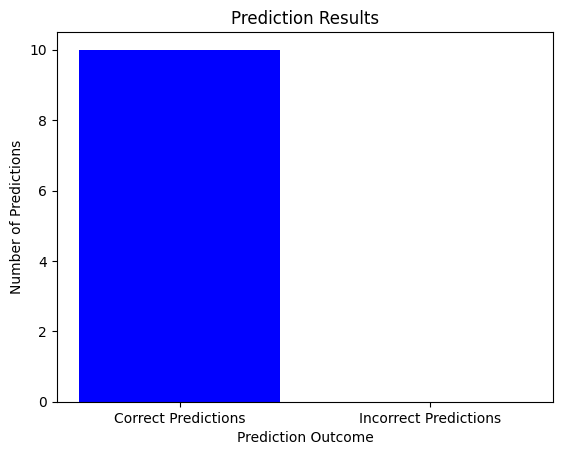

In [128]:
# obtains first 10 files & expected labels from train data and loads into a list
test_list = train["file_name"].values[:10].tolist()
expected_labels = train["label"].values[:10].tolist()

# tests model based on the dataset loaded
test_model(model, test_list, expected_labels)

✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated I

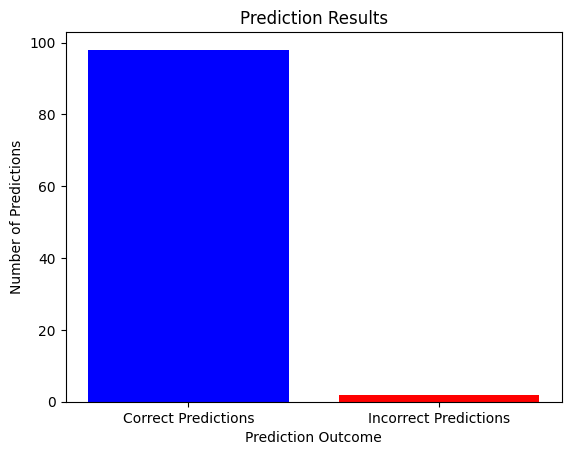

In [129]:
# obtains first 100 files & expected labels from train data and loads into a list
test_list = train["file_name"].values[:100].tolist()
expected_labels = train["label"].values[:100].tolist()

# tests model based on the dataset loaded
test_model(model, test_list, expected_labels)

✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated I

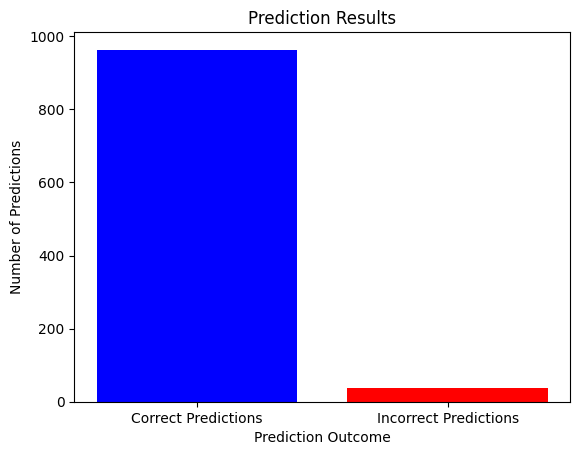

In [130]:
# obtains first 1000 files & expected labels from train data and loads into a list
test_list = train["file_name"].values[:1000].tolist()
expected_labels = train["label"].values[:1000].tolist()

# tests model based on the dataset loaded
test_model(model, test_list, expected_labels)

✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated I

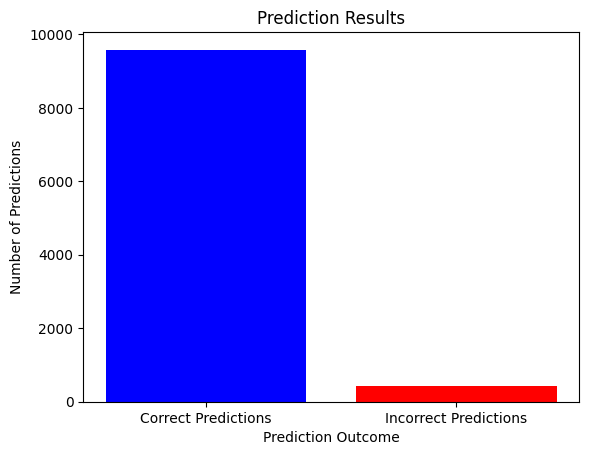

In [131]:
# obtains first 10000 files & expected labels from train data and loads into a list
test_list = train["file_name"].values[:10000].tolist()
expected_labels = train["label"].values[:10000].tolist()

# tests model based on the dataset loaded
test_model(model, test_list, expected_labels)

✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated Image Expected: AI Generated Image
✅ Prediction: Real Image Expected: Real Image
✅ Prediction: AI Generated I

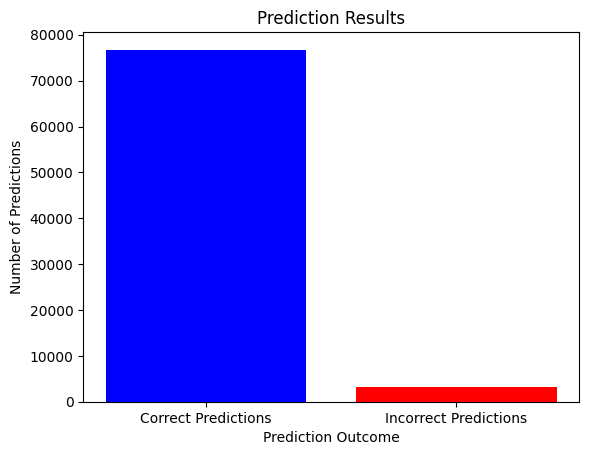

In [132]:
# obtains ALL files & expected labels from train data and loads into a list
test_list = train["file_name"].values.tolist()
expected_labels = train["label"].values.tolist()

# tests model based on the dataset loaded
test_model(model, test_list, expected_labels)

In [133]:
file_path = "test.csv" # load test.csv from kaggle api

# Load the latest version
test = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "alessandrasala79/ai-vs-human-generated-dataset",
  file_path,
)

# example of csv
print("First 5 records:", test.head())

C:\Users\ryanc\AppData\Local\Temp\ipykernel_27924\683475352.py:4: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  test = kagglehub.load_dataset(


First 5 records:                                                   id
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


In [135]:
# this function runs the model through 5 random images that don't have expected labels
def test_random_images(model, images, num_images=5):
    plt.figure(figsize=(15, 5))
    # loops through a random sample of 5 images
    for i, image in enumerate(random.sample(images,num_images)):
        img = Image.open(image).convert('RGB') # opens image and converts rgb
        img = img.resize((128,128)) # resize to (128,128)
        img_array = np.array(img) / 255.0 # converts to array and normalizes pixels
        img_array = np.expand_dims(img_array, axis=0) # shape should be (128, 128, 3)
        prediction = model(img_array) # pass image to model
        pred_label = get_prediction(prediction) # output prediction and save

        str = "AI Generated Image" if pred_label == 1 else "Real Image" # creates the title for each image

        plt.subplot(1, num_images, i + 1) # add image to subplot
        plt.imshow(img) # displays image
        plt.title(str) # adds title
        plt.axis('off')

    plt.show()

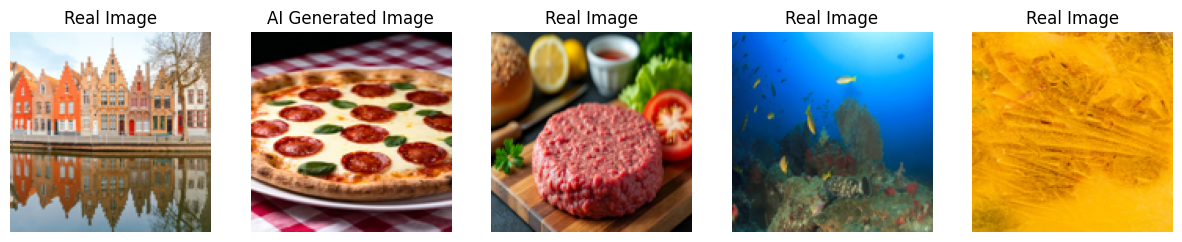

In [136]:
random_images = test["id"].values.tolist() # adds all test images from test_data to a list
test_random_images(model, random_images, num_images=5) # tests 5 random images from the data

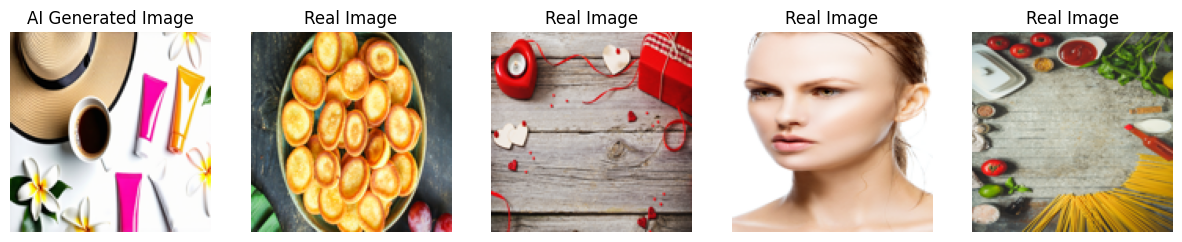

In [137]:
random_images = test["id"].values.tolist() # adds all test images from test_data to a list
test_random_images(model, random_images, num_images=5) # tests 5 random images from the data

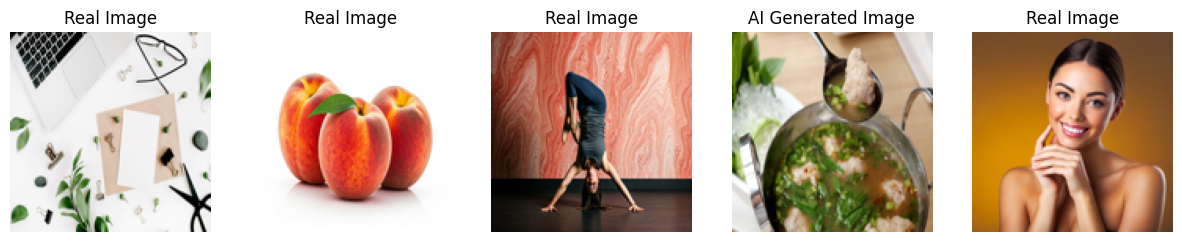

In [138]:
random_images = test["id"].values.tolist() # adds all test images from test_data to a list
test_random_images(model, random_images, num_images=5) # tests 5 random images from the data